In [1]:
import json, numpy as np, pandas as pd, time
from collections import defaultdict, OrderedDict
from copy import deepcopy
import datetime
from pandas import *
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
task_name = "政府网站"  # 诚信数据 政府网站 新闻
check_start_date = '2019.5'  # eg: 2018.6 or 2018, if just year, it will be marked as January
check_end_date = ''  # default is Now Time

In [3]:
developer = ["陈子昂", "胡耀龙", "金伟", "郭正霆", "余依哲"]
developer_done_states = {'代码完成', '开发完成'}
developer_modify_states = {'研发修改完成'}
states = ["开发完成", "修改完成"]

In [4]:
if '.' in check_start_date and check_start_date.count('.') < 2:
    check_start_year, check_start_month = [int(date) for date in check_start_date.split('.')]
else:
    check_start_year = int(check_start_date)
    check_start_month = 1
check_start_timestamp = int(datetime.datetime(check_start_year, check_start_month, 1).timestamp())
try:
    if check_end_date:
        if '.' in check_end_date and check_end_date.count('.') < 2:
            check_end_year, check_end_month = [int(date) for date in check_end_date.split('.')]
        else:
            check_end_year = int(check_start_date)
            check_end_month = 1
        check_end_timestamp = int(datetime.datetime(check_end_year, check_end_month, 1).timestamp())
        check_end_date_flag = 1
    else:
        check_end_date_flag = 0
except:
    check_end_date_flag = 0
def get_data(name, version=1, flag=False):
    try:
        with open('%s.json' % name, 'r', encoding='utf-8') as json_file:
            return json.loads(json_file.read())[name]
    except FileNotFoundError:
        if flag:
            raise Exception('二次加载数据失败！')
        try:
            from mysql_database import get_version_data
            get_version_data(name, version)
            return get_data(name, version, True)
        except:
            raise Exception('没有对应的JSON文件，也没有加载数据的代码，请联系开发！')
def get_spider_tasks(data_list, key=None, dupefilter=()):
    spider_tasks = defaultdict(list)
    for data in data_list:
        if data[key or 'spiderName'] in dupefilter:
            continue
        spider_tasks[data[key or 'spiderName']].append(data)
    return spider_tasks
task_data = get_data(task_name)
spider_tasks = get_spider_tasks(task_data, key='by')
spider_tasks = {key:value for key, value in spider_tasks.items() if key in developer}

In [5]:
def get_time_format(timestamp):
    current_time = datetime.datetime.fromtimestamp(timestamp)
    year = current_time.year
    month = current_time.month
    day = current_time.day
    return f'{year}年{month}月', f'{year}年{month}月{day}日'
def get_date_template(check_start_year, check_start_month, end_year=None, end_month=None):
    if all((end_year, end_month)):
        year, month = end_year, end_month
    elif not check_end_date_flag:
        now = datetime.datetime.now()
        year, month = now.year, now.month
    else:
        year, month = check_end_year, check_end_month
    date_template = OrderedDict()
    time_format_1 = '%d年%d月'
    while check_start_year <= year:
        if check_start_month < 13:
            date_template[time_format_1 % (check_start_year, check_start_month)] = 0
            if check_start_year == year and check_start_month == month:
                break
            check_start_month += 1
        else:
            check_start_year += 1
            check_start_month = 1
            date_template[time_format_1 % (check_start_year, check_start_month)] = 0
    return date_template
date_template = get_date_template(check_start_year, check_start_month)

In [6]:
user_info = {}
for key, tasks in spider_tasks.items():
    done_count = modify_count = 0
    done_date_count = {}
    modify_date_count = {}
    for task in tasks:
        date_key = get_time_format(task['time'])[0]
        if task['rwzt'] in developer_done_states:
            done_count += 1
            done_date_count[date_key] = done_date_count.setdefault(date_key, 0) + 1
        if task['rwzt'] in developer_modify_states:
            modify_count += 1
            modify_date_count[date_key] = modify_date_count.setdefault(date_key, 0) + 1
    done_date_count['count'] = done_count
    modify_date_count['count'] = modify_count
    user_info[key] = dict(done=done_date_count, modify=modify_date_count)
# user_info

In [7]:
user_info_count = []
for key, value in user_info.items():
    user_info_count.append([value['done']['count'], value['modify']['count']])

for key in date_template:
    date_template[key] = [[0,0] for i in range(len(developer))]
for i, name in enumerate(developer):
    for month, value in user_info[name]['done'].items():
        if month in date_template:
            date_template[month][i][0] = value
    for month, value in user_info[name]['modify'].items():
        if month in date_template:
            date_template[month][i][1] = value
# print(user_info_count)
# date_template

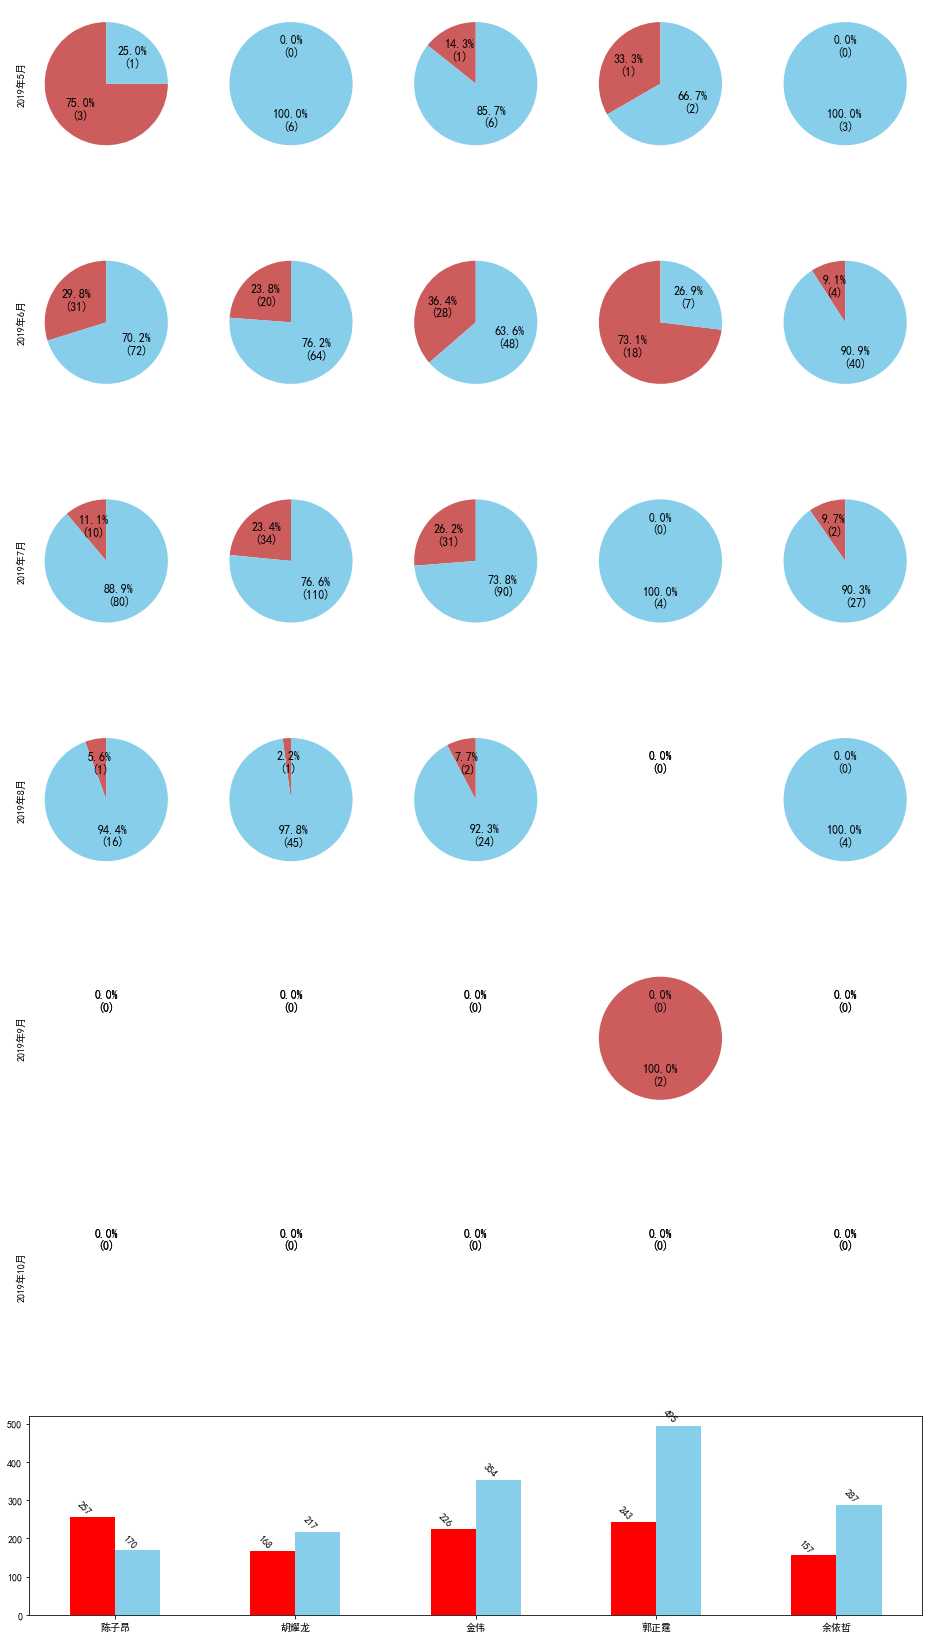

In [8]:
keys = list(date_template.keys())
values = list(date_template.values())
users_num = len(developer)
fig = plt.figure(1, figsize=(16, 30))
def autolabel(rects, xpos='center', add_percentage=None):
        xpos = xpos.lower()  # normalize the case of the parameter
        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
        for index, rect in enumerate(rects):
            height = rect.get_height()
            if add_percentage is None:
                text = '{}'.format(height)
            else:
                text = '{}({}%)'.format(height, str(int(rects1_values[add_percentage][index]*100)))
            ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height, text, ha='right', va='bottom', rotation=-45)
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
def draw(xyz=(0, 0, 0), key=None, value=None):
    a = fig.add_subplot(*xyz)
    index = (xyz[2] - 1) % users_num
    if index == 0:
        a.set_ylabel(key)
    autotexts = plt.pie(value[index], autopct=lambda pct: func(pct, value[index]), shadow=False,
                        colors=['IndianRed', 'SkyBlue'], startangle=90)[2]
    plt.setp(autotexts, size='large')
count = 1
for i in range(0, len(keys)):
    key = keys[i]
    value = values[i]
    for j in range(0, users_num):
        draw(xyz=(users_num + 2, users_num, count), key=key, value=value)
        count += 1
# fig.legend(states, loc="upper right")
ax = fig.add_subplot(*(users_num + 2, 1, users_num + 2))
ind = np.arange(users_num)
width = 0.25
rects1 = plt.bar(ind-width/2, [i[0] for i in user_info_count], width, color='red', label='开发完成')
rects2 = plt.bar(ind+width/2, [i[1] for i in user_info_count], width, color='skyblue', label='修改完成')
autolabel(rects1, "center")
autolabel(rects2, "center")
ax.set_xticks(ind)
ax.set_xticklabels(developer)
plt.show()